In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import random
import os
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
import lifelines.statistics
import math 

sns.set_theme()
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# DP - Mechanism Definitions

### Laplacian Noise Time Obfuscation (LNTO)

In [2]:
def lnto_grouped(df, epsilon, column_group):
    # Initialize an empty DataFrame to store concatenated results
    final_df = pd.DataFrame()
    # Initialize an empty DataFrame to store median times and CIs
    median_df = pd.DataFrame()

    # Alpha for confidence intervals (95% CI)
    alpha = 0.05
    z_score = -np.percentile(np.random.standard_normal(10000), alpha / 2 * 100)  # Two-tailed inverse of normal

    # Iterate over each unique value in the column_group
    for group_value, group_df in df.groupby(column_group):
        # Sort the dataframe by time
        df_sorted = group_df.sort_values(by='Time')

        # Get unique times and count events and at risk
        unique_times = df_sorted['Time'].unique()
        result = []
        n = len(df_sorted)  # Total number of subjects initially at risk
        for time in unique_times:
            # Number of events at time t_j
            d_j = df_sorted[(df_sorted['Time'] == time) & (df_sorted['Status'] == 1)].shape[0]
            
            # Append the result for this time
            result.append((time, n, d_j))
            
            # Update the number at risk
            n -= df_sorted[df_sorted['Time'] == time].shape[0]

        # Convert result list to matrix for differential privacy calculations
        D = np.array(result)  # Convert to numpy array for processing
        k = D.shape[0]  # number of timestamps

        # Create the partial matrix M' by adding Laplace noise to r_j and d_j
        M_prime = D[:, 1:3].copy()  # Copy r_j and d_j columns
        for j in range(k):
            M_prime[j, 0] += np.random.laplace(0, 1/epsilon)  # Add noise to r_j
            M_prime[j, 1] += np.random.laplace(0, 1/epsilon)  # Add noise to d_j

        # Initialize the survival probability estimates and their variances
        S_prime = np.ones(k)
        Var_prime = np.zeros(k)  # Variance of the survival estimates

        # Calculate differentially private estimates of survival probabilities and their variances
        for j in range(1, k):
            r_prime = M_prime[j-1, 0] - M_prime[j-1, 1]  # Updated number of subjects at risk
            M_prime[j, 0] = r_prime  # Update r_j' for the next time interval
            if r_prime > 0:  # Avoid division by zero
                S_prime[j] = S_prime[j-1] * (r_prime - M_prime[j, 1]) / r_prime
                Var_prime[j] = Var_prime[j-1] + (M_prime[j, 1] / (r_prime * (r_prime - M_prime[j, 1]))) if M_prime[j, 1] > 0 else Var_prime[j-1]

        # Calculate confidence intervals
        CI_lower = S_prime - z_score * np.sqrt(Var_prime)
        CI_upper = S_prime + z_score * np.sqrt(Var_prime)

        # Find median survival time, where S(t) = 0.5
        median_index = np.where(S_prime <= 0.5)[0]
        median_time = D[median_index[0], 0] if len(median_index) > 0 else np.nan  # Assumes time is sorted

        # Interpolate CI for median time
        median_CI_lower = np.interp(median_time, D[:, 0], CI_lower) if len(median_index) > 0 else np.nan
        median_CI_upper = np.interp(median_time, D[:, 0], CI_upper) if len(median_index) > 0 else np.nan

        # Append median time and CI to the median_df
                # Complete the DataFrame for survival probabilities
        temp = pd.DataFrame({
            'Time': D[:, 0], 
            'S': S_prime, 
            'CI_lower': CI_lower, 
            'CI_upper': CI_upper
        })
        temp['Time'] = temp['Time'].astype(float)  # Ensure time is in float for consistency
        temp[column_group] = group_value  # Assign the current group value for identification

        # Append the results to the final DataFrame
        final_df = pd.concat([final_df, temp], ignore_index=True)

                # Calculate the median survival time
        median_index = np.where(S_prime <= 0.5)[0]
        median_time = round(D[median_index[0], 0], 2) if len(median_index) > 0 else np.nan  # Round to 2 decimal places

        # Find the times when the CI crosses 0.5 for the median
        # This requires finding where the CI_lower and CI_upper arrays first become less than 0.5
        lower_cross = np.where(CI_lower <= 0.5)[0]
        upper_cross = np.where(CI_upper <= 0.5)[0]
        median_CI_lower_time = round(D[lower_cross[0], 0], 2) if len(lower_cross) > 0 else np.nan  # Round to 2 decimal places
        median_CI_upper_time = round(D[upper_cross[0], 0], 2) if len(upper_cross) > 0 else np.nan  # Round to 2 decimal places

        # Append median information to the median_df
        median_info = {
            column_group: group_value,
            'Median_Time': median_time,
            'CI_lower_time': median_CI_lower_time,
            'CI_upper_time': median_CI_upper_time
        }
        median_df = pd.concat([median_df, pd.DataFrame([median_info])], ignore_index=True)


    # Return both the complete survival data and median survival times with CIs
    return final_df, median_df





### Revised Randomize Response (RRR)

In [3]:
# check if the possible epsilon is negative
def verify_epsilon(p,n):
    epsilon = np.log((n*p+1-p)/(n-1-n*p+p))
    if epsilon <= 0:
        #print('epsilon is negative for such values of p and n')
        return None
    else:
        return epsilon

In [4]:
def revised_coin_toss(category, list_of_cathegories, n, p):
    cathegories = list_of_cathegories
    '''
    category: IPSS-R category, value to be privatized
    list_of_uniques: list of unique cathegories
    n: number of categories (not used in this function, used to compute the epsilon)
    p: coin bias
    '''    
    # compute epsilon
    epsilon = verify_epsilon(p,n)

    # toss a coin H with probability p, T with probability 1-p
    coin = np.random.choice(['H', 'T'], p=[p, 1-p])

    # if coin is H, return the original value
    if coin == 'H':
        return category
    
    # if coin is T, return a random value from the n categories
    else:
        #return a random value from the list of unique values
        return random.choice(list_of_cathegories)


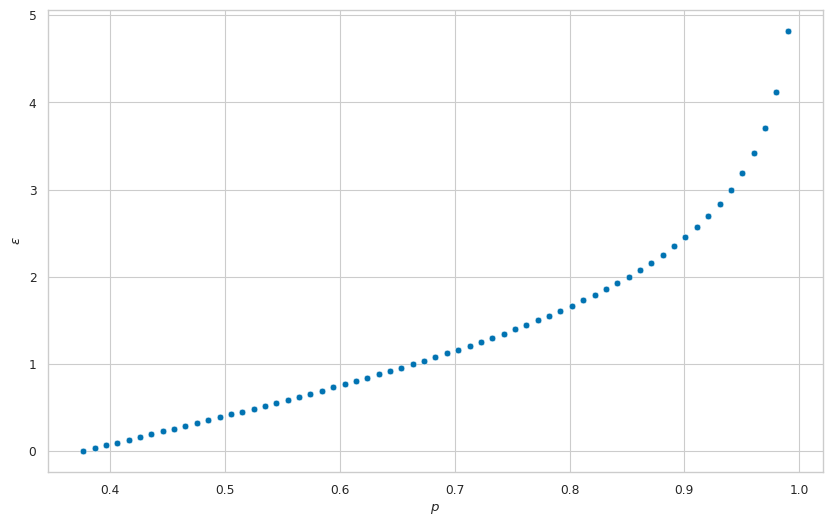

In [5]:
#plot a table of two columns, one is p and the other is the corresponding epsilon
def plot_epsilon(p_values, n):
    epsilons = []
    for p in p_values:
        epsilon = verify_epsilon(p,n)
        epsilons.append(epsilon)
    df = pd.DataFrame({'p': p_values, 'epsilon': epsilons})
    return df

#do an example of the plots
#create a list of p_values to be tested
p_values = np.linspace(0.01, 0.99, 100)
n = 5
df = plot_epsilon(p_values, n)
#plot a distribution of the epsilon
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='p', y='epsilon')
plt.xlabel(r'$p$')
plt.ylabel(r'$\varepsilon$')
#plt.title(r'$\varepsilon$ as a function of $p$ for a fixed number of cathegories $n =$' + f'{n}')
plt.show()



# IPSS-R Dataset

Bernard et al. dataset. URL: https://evidence.nejm.org/doi/full/10.1056/EVIDoa2200008

In [6]:
#define path to data
data_path = "../data/"
bernard = "BernardEtAl/"

#read the data
path_verylow = data_path+bernard+'veryLow.tsv'
df_verylow = pd.read_csv(path_verylow, sep='\t')
path_low = data_path+bernard+'low.tsv'
df_low = pd.read_csv(path_low, sep='\t')
path_int = data_path+bernard+'int.tsv'
df_int = pd.read_csv(path_int, sep='\t')
path_high = data_path+bernard+'high.tsv'
df_high = pd.read_csv(path_high, sep='\t')
path_veryhigh = data_path+bernard+'veryHigh.tsv'
df_veryhigh = pd.read_csv(path_veryhigh, sep='\t')

# Add a column with the risk group to each of the dataframes
df_verylow['Risk Group'] = 'Very Low'
df_low['Risk Group'] = 'Low'
df_int['Risk Group'] = 'Intermediate'
df_high['Risk Group'] = 'High'
df_veryhigh['Risk Group'] = 'Very High'

# Concatenate the dataframes
df = pd.concat([df_verylow, df_low, df_int, df_high, df_veryhigh]).reset_index(drop=True)

df['Status'] = df['Status'].map({'censored': 0, 'deceased': 1})
#eliminate columns
df = df.drop(['Case ID', 'Study ID', 'Survival Rate'], axis=1)
#raname columns
df = df.rename(columns={'Time (months)': 'Time'})

df_ipssr = df.copy()
df

,Number at Risk,Status,Time,Risk Group
0,482,0,0.000000,Very Low
1,481,0,0.000000,Very Low
2,480,0,0.000000,Very Low
3,479,0,0.000000,Very Low
4,478,0,0.000000,Very Low
...,...,...,...,...
2995,5,0,77.786301,Very High
2996,4,1,79.923288,Very High
2997,3,0,97.380822,Very High
2998,2,0,129.665753,Very High


## Group Survival Analysis

### LNTO Simulation

In [7]:
df_lnto, median_lnto = lnto_grouped(df_ipssr, 1, 'Risk Group')
median_lnto

,Risk Group,Median_Time,CI_lower_time,CI_upper_time
0,High,22.32,17.92,36.92
1,Intermediate,49.97,28.37,NaN
2,Low,NaN,NaN,NaN
3,Very High,14.10,10.39,25.35
4,Very Low,NaN,110.70,NaN


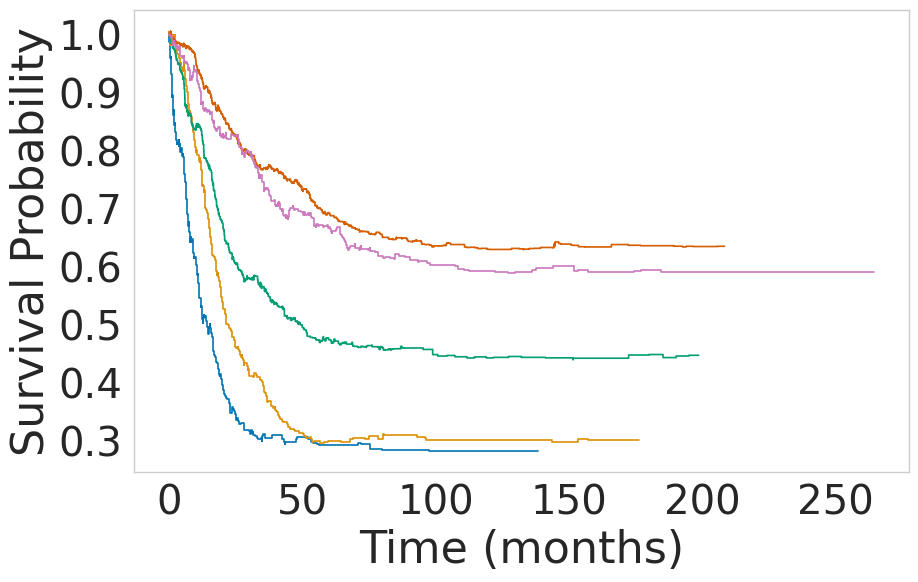

In [8]:
plt.figure(figsize=(10,6))
risk_groups = df_lnto['Risk Group'].unique()
for group in ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']:
    # Filter the data for the current group
    group_data = df_lnto[df_lnto['Risk Group'] == group]
    times = np.array(group_data['Time'])
    S = np.array(group_data['S'])
    #sort by time and respective survival probability
    times, S = zip(*sorted(zip(times, S)))
    plt.step(times, S, label=group)
    
plt.xlabel('Time (months)', size=32)
plt.xticks(size=29)
plt.ylabel('Survival Probability', size=32)
plt.yticks(size=29)
plt.set_ylim = (0,1)
#plt.title('Survival Probability for IPSS-R Risk Groups')
plt.legend(title='Risk Group')
plt.legend().remove()
plt.grid(False)
plt.show()


In [9]:
df_lnto, median_lnto = lnto_grouped(df_ipssr, 2, 'Risk Group')
median_lnto

,Risk Group,Median_Time,CI_lower_time,CI_upper_time
0,High,20.35,16.21,36.53
1,Intermediate,61.22,38.53,NaN
2,Low,NaN,NaN,NaN
3,Very High,12.66,9.44,25.48
4,Very Low,NaN,NaN,NaN


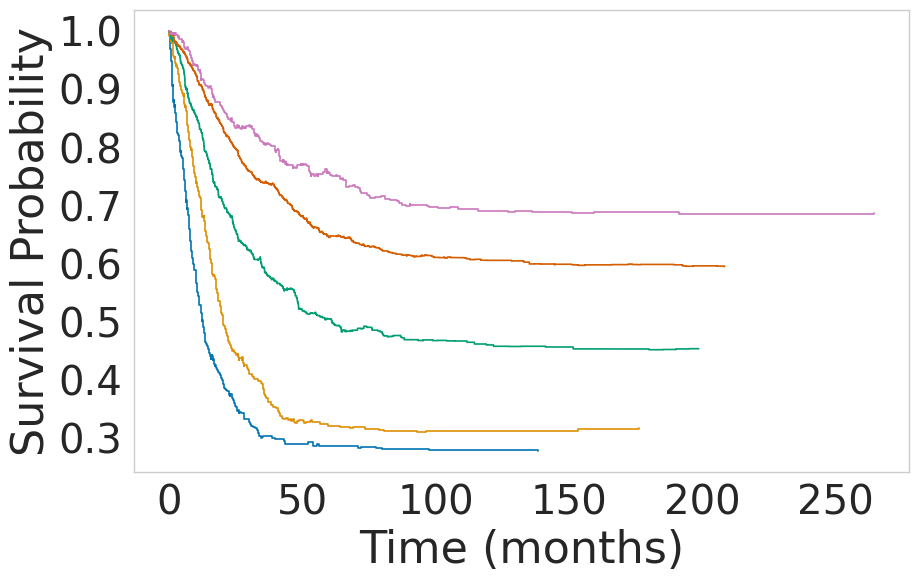

In [10]:
plt.figure(figsize=(10,6))
risk_groups = df_lnto['Risk Group'].unique()
for group in ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']:
    # Filter the data for the current group
    group_data = df_lnto[df_lnto['Risk Group'] == group]
    times = np.array(group_data['Time'])
    S = np.array(group_data['S'])
    #sort by time and respective survival probability
    times, S = zip(*sorted(zip(times, S)))
    plt.step(times, S, where='post', label=group)
    
plt.xlabel('Time (months)', size=32)
plt.xticks(size=29)
plt.ylabel('Survival Probability', size=32)
plt.yticks(size=29)
plt.set_ylim = (0,1)
#plt.title('Survival Probability for IPSS-R Risk Groups')
plt.legend(title='Risk Group')
plt.legend().remove()
plt.grid(False)
plt.show()


In [11]:
df_lnto, median_lnto = lnto_grouped(df_ipssr, 3, 'Risk Group')
median_lnto

,Risk Group,Median_Time,CI_lower_time,CI_upper_time
0,High,20.15,15.98,35.61
1,Intermediate,55.43,36.16,NaN
2,Low,NaN,NaN,NaN
3,Very High,11.28,8.78,18.02
4,Very Low,NaN,NaN,NaN


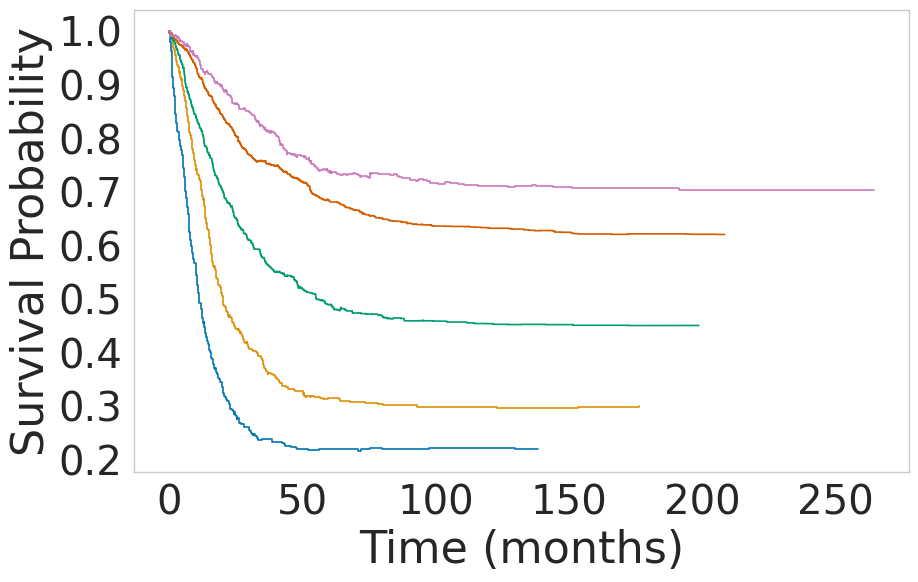

In [12]:
plt.figure(figsize=(10,6))
risk_groups = df_lnto['Risk Group'].unique()
for group in ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']:
    # Filter the data for the current group
    group_data = df_lnto[df_lnto['Risk Group'] == group]
    times = np.array(group_data['Time'])
    S = np.array(group_data['S'])
    #sort by time and respective survival probability
    times, S = zip(*sorted(zip(times, S)))
    plt.step(times, S, where='post', label=group)
    
plt.xlabel('Time (months)', size=32)
plt.xticks(size=29)
plt.ylabel('Survival Probability', size=32)
plt.yticks(size=29)
plt.set_ylim = (0,1)
#plt.title('Survival Probability for IPSS-R Risk Groups')
plt.legend(title='Risk Group')
plt.legend().remove()
plt.grid(False)
plt.show()


### RRR Simulation

In [13]:
#get unique risks groups
risk_groups = df['Risk Group'].unique()
risk_groups

array(['Very Low', 'Low', 'Intermediate', 'High', 'Very High'],
      dtype=object)

In [14]:
# Set global font size
#plt.rcParams.update({'font.size': 24})  # You can adjust the size as needed
#
#def plot_km_curves_for_epsilon(df, n, e1_val, show_y_labels, show_legend):
#    # Set the coin bias according to e1
#    if e1_val == 1:
#        p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#    elif e1_val == 2:
#        p = (math.pow(np.exp(1), 2)*(n-1)-1)/((1+math.pow(np.exp(1), 2))*(n-1))
#    elif e1_val == 3:
#        p = (math.pow(np.exp(1), 3)*(n-1)-1)/((1+math.pow(np.exp(1), 3))*(n-1))
#    
#    e1 = verify_epsilon(p, n)
#    # Privatize the IPSS-R category
#    df['Privatized Risk Group'] = df['Risk Group'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p))
#
#    # Define risk groups
#    groups = df['Privatized Risk Group']
#    ix_vl = (groups == 'Very Low')
#    ix_l = (groups == 'Low')
#    ix_i = (groups == 'Intermediate')
#    ix_h = (groups == 'High')
#    ix_vh = (groups == 'Very High')
#
#    # Initialize KaplanMeierFitter
#    km = KaplanMeierFitter()
#
#    # Fitting and plotting for each risk group
#    for ix, label in zip([ix_vh, ix_h, ix_i, ix_l, ix_vl], ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']):
#        km.fit(df['Time'][ix], df['Status'][ix], label=label)
#        km.plot(ax=plt.gca(), ci_show=False)  # Use the current axes, overlaying the plots
#
#    if not show_y_labels:
#        plt.gca().set_ylabel('')  # Remove y label
#        plt.gca().set_yticklabels([])  # Remove y tick labels
#    
#    plt.title(r'Kaplan Meier Estimate by Risk Group ($\epsilon$ = {})'.format(round(e1, 2)))
#    plt.xlabel('Time (months)')
#    if show_y_labels:
#        plt.ylabel('Survival Probability')
#    if show_legend:
#        plt.legend(title='Risk Groups', loc='best')
#    else:
#        plt.gca().get_legend().remove()  # Remove legend if not the last plot
#
## Main plotting
#fig, axes = plt.subplots(1, 3, figsize=(30, 7))  # Adjust the size as needed
#for i, e1_val in enumerate([1, 2, 3]):
#    plt.sca(axes[i])  # Set the current axes
#    plot_km_curves_for_epsilon(df, len(risk_groups), e1_val, show_y_labels=(i == 0), show_legend=(i == 2))
#
#plt.tight_layout()
#plt.grid(False)
#plt.show()
#

epsilon: 1.0


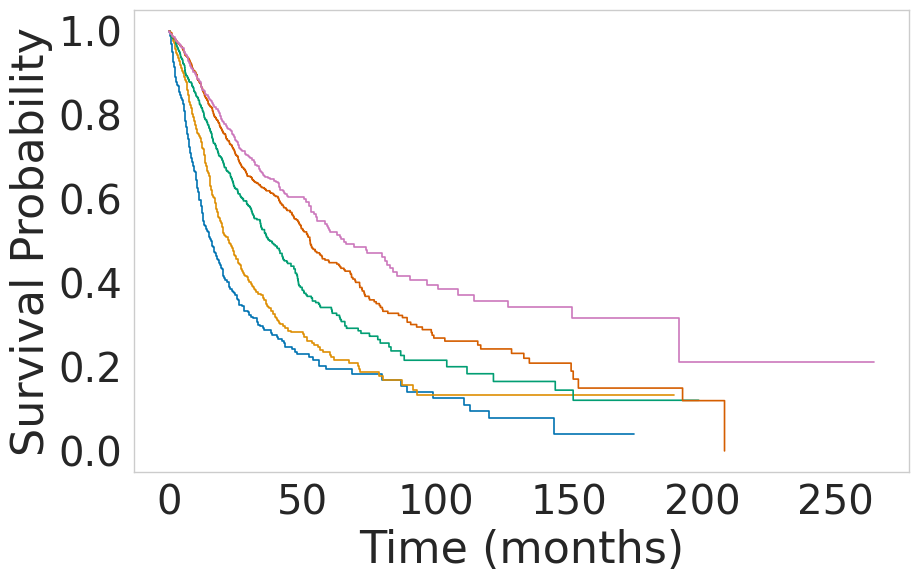

In [15]:
plt.rcParams.update({'font.size': 64})
# set the coin bias
#e1 = 1 -> p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#e1 = 2 -> p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
#e1 = 3 -> p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
n = len(risk_groups)

p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
#p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
e1 = verify_epsilon(p, n)
print(f'epsilon: {e1}')
# privatize the IPSS-R category
df['Privatized Risk Group'] = df['Risk Group'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p))

groups = df['Privatized Risk Group']
ix_vl = (groups == 'Very Low')
ix_l = (groups == 'Low')
ix_i = (groups == 'Intermediate')
ix_h = (groups == 'High')
ix_vh = (groups == 'Very High')

km = KaplanMeierFitter()

plt.figure(figsize=(10, 6))  # Setting the figure size

# Fitting and plotting for each risk group
medians = []
medians_ci = []
for ix, label in zip([ix_vh, ix_h, ix_i, ix_l, ix_vl], ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']):
    km.fit(df['Time'][ix], df['Status'][ix], label=label)
    medians.append(km.median_survival_time_)
    medians_ci.append(median_survival_times(km.confidence_interval_))
    km.plot(ax=plt.gca(), ci_show=False)  # Use the current axes, overlaying the plots

#plt.title(r'Kaplan Meier Estimate by Risk Group ($\epsilon$ = {})'.format(round(e1, 2)))
plt.xlabel('Time (months)', size=32)
plt.xticks(size=29)
plt.ylabel('Survival Probability', size=32)
plt.yticks(size=29)
#plt.legend(title='Risk Groups', loc = 'best', fontsize = 20, title_fontsize = 20)
#remove the legend
plt.legend().remove()
#remove the grid
plt.grid(False)
plt.show()

In [16]:
for median, ci in zip(medians, medians_ci):
    print('Median survival time:', "{:.2f}".format(median))
    print(ci)

Median survival time: 15.68
     Very High_lower_0.95  Very High_upper_0.95
0.5             12.821918             18.871233
Median survival time: 22.32
     High_lower_0.95  High_upper_0.95
0.5        19.232877        25.841096
Median survival time: 37.74
     Intermediate_lower_0.95  Intermediate_upper_0.95
0.5                34.191781                43.232877
Median survival time: 52.93
     Low_lower_0.95  Low_upper_0.95
0.5       48.986301        57.50137
Median survival time: 65.62
     Very Low_lower_0.95  Very Low_upper_0.95
0.5            55.528767            82.947945


epsilon: 1.9999999999999998


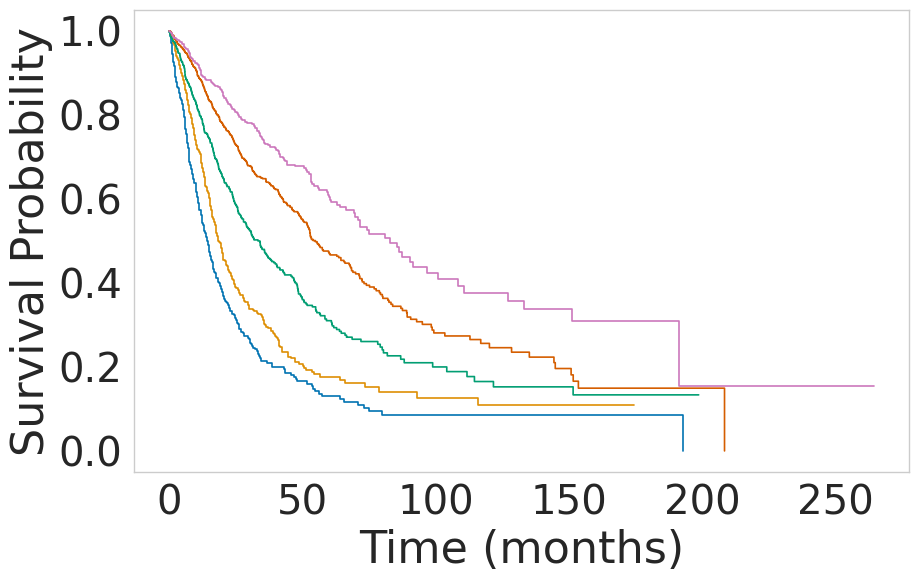

In [17]:
plt.rcParams.update({'font.size': 64})
# set the coin bias
#e1 = 1 -> p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#e1 = 2 -> p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
#e1 = 3 -> p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
n = len(risk_groups)

#p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
#p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
e1 = verify_epsilon(p, n)
print(f'epsilon: {e1}')
# privatize the IPSS-R category
df['Privatized Risk Group'] = df['Risk Group'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p))

groups = df['Privatized Risk Group']
ix_vl = (groups == 'Very Low')
ix_l = (groups == 'Low')
ix_i = (groups == 'Intermediate')
ix_h = (groups == 'High')
ix_vh = (groups == 'Very High')

km = KaplanMeierFitter()

plt.figure(figsize=(10, 6))  # Setting the figure size

# Fitting and plotting for each risk group
medians = []
medians_ci = []
for ix, label in zip([ix_vh, ix_h, ix_i, ix_l, ix_vl], ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']):
    km.fit(df['Time'][ix], df['Status'][ix], label=label)
    medians.append(km.median_survival_time_)
    medians_ci.append(median_survival_times(km.confidence_interval_))
    km.plot(ax=plt.gca(), ci_show=False)  # Use the current axes, overlaying the plots

#plt.title(r'Kaplan Meier Estimate by Risk Group ($\epsilon$ = {})'.format(round(e1, 2)))
plt.xlabel('Time (months)', size=32)
plt.xticks(size=29)
plt.ylabel('Survival Probability', size=32)
plt.yticks(size=29)
#plt.legend(title='Risk Groups', loc = 'best', fontsize = 20, title_fontsize = 20)
#remove the legend
plt.legend().remove()
#remove the grid
plt.grid(False)
plt.show()

In [18]:
for median, ci in zip(medians, medians_ci):
    print('Median survival time:', "{:.2f}".format(median))
    print(ci)

Median survival time: 14.27
     Very High_lower_0.95  Very High_upper_0.95
0.5              12.29589             16.273973
Median survival time: 18.38
     High_lower_0.95  High_upper_0.95
0.5        16.668493        21.238356
Median survival time: 33.34
     Intermediate_lower_0.95  Intermediate_upper_0.95
0.5                28.569863                 38.20274
Median survival time: 54.87
     Low_lower_0.95  Low_upper_0.95
0.5       51.780822       64.471233
Median survival time: 82.95
     Very Low_lower_0.95  Very Low_upper_0.95
0.5            69.764384           100.767123


epsilon: 3.0000000000000013


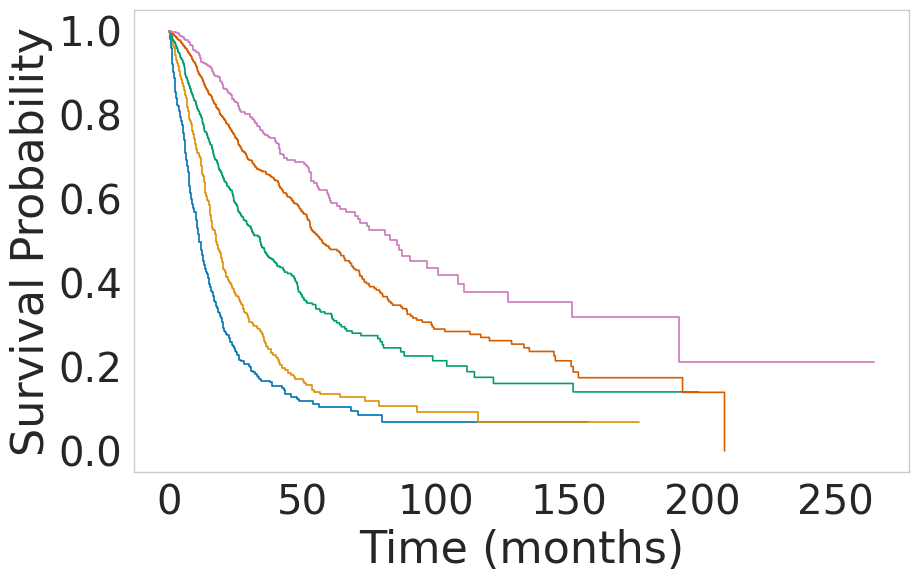

In [19]:
plt.rcParams.update({'font.size': 64})
# set the coin bias
#e1 = 1 -> p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#e1 = 2 -> p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
#e1 = 3 -> p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
n = len(risk_groups)

#p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
e1 = verify_epsilon(p, n)
print(f'epsilon: {e1}')
# privatize the IPSS-R category
df['Privatized Risk Group'] = df['Risk Group'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p))

groups = df['Privatized Risk Group']
ix_vl = (groups == 'Very Low')
ix_l = (groups == 'Low')
ix_i = (groups == 'Intermediate')
ix_h = (groups == 'High')
ix_vh = (groups == 'Very High')

km = KaplanMeierFitter()

plt.figure(figsize=(10, 6))  # Setting the figure size

# Fitting and plotting for each risk group
medians = []
medians_ci = []
for ix, label in zip([ix_vh, ix_h, ix_i, ix_l, ix_vl], ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']):
    km.fit(df['Time'][ix], df['Status'][ix], label=label)
    medians.append(km.median_survival_time_)
    medians_ci.append(median_survival_times(km.confidence_interval_))
    km.plot(ax=plt.gca(), ci_show=False)  # Use the current axes, overlaying the plots

#plt.title(r'Kaplan Meier Estimate by Risk Group ($\epsilon$ = {})'.format(round(e1, 2)))
plt.xlabel('Time (months)', size=32)
plt.xticks(size=29)
plt.ylabel('Survival Probability', size=32)
plt.yticks(size=29)
#plt.legend(title='Risk Groups', loc = 'best', fontsize = 20, title_fontsize = 20)
#remove the legend
plt.legend().remove()
#remove the grid
plt.grid(False)
plt.show()

In [20]:
for median, ci in zip(medians, medians_ci):
    print('Median survival time:', "{:.2f}".format(median))
    print(ci)

Median survival time: 11.38
     Very High_lower_0.95  Very High_upper_0.95
0.5             10.126027             13.052055
Median survival time: 17.65
     High_lower_0.95  High_upper_0.95
0.5        15.715068        20.021918
Median survival time: 34.19
     Intermediate_lower_0.95  Intermediate_upper_0.95
0.5                 29.09589                38.531507
Median survival time: 57.47
     Low_lower_0.95  Low_upper_0.95
0.5       52.931507       65.983562
Median survival time: 85.35
     Very Low_lower_0.95  Very Low_upper_0.95
0.5            69.764384            108.39452


In [21]:
p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
e = verify_epsilon(p, n)
times = 100

# Fitting and plotting for each risk group
medians = []
medians_ci = []
dfs = []
for i in range(1, times+1):
    df['Privatized Cancer Group'] = df['Risk Group'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p))
    groups = df['Privatized Cancer Group']
    ix_vl = (groups == 'Very Low')
    ix_l = (groups == 'Low')
    ix_i = (groups == 'Intermediate')
    ix_h = (groups == 'High')
    ix_vh = (groups == 'Very High')
    
    km = KaplanMeierFitter()
    for ix, label in zip([ix_vh, ix_h, ix_i, ix_l, ix_vl], ['Very High', 'High', 'Intermediate', 'Low', 'Very Low']):
        km.fit(df['Time'][ix], df['Status'][ix], label=label)
        medians.append(km.median_survival_time_)
        medians_ci.append(median_survival_times(km.confidence_interval_))
    results_dp = lifelines.statistics.pairwise_logrank_test(df['Time'], df['Privatized Cancer Group'], df['Status'])
    temp = pd.DataFrame(results_dp.summary)
    temp['iteration'] = i
    dfs.append(temp)

In [22]:
results = lifelines.statistics.pairwise_logrank_test(df['Time'], df['Risk Group'], df['Status'])

In [23]:
#concatenate all df in dfs, summing the values of the test statistic and counting the proportion of p-values < 0.05 for each index
df_results = pd.concat(dfs)
df_results = df_results.reset_index()
#group by level_0 and level_1 and sum the values of the test statistic and count the proportion of p-values < 0.05
df_results = df_results.groupby(['level_0', 'level_1']).agg({'test_statistic': 'sum', 'p': lambda x: (x < 0.05).sum()/len(x)}).reset_index()

#pivot the table
df_results = df_results.pivot(index='level_0', columns='level_1', values='p')

df_results


level_1,Intermediate,Low,Very High,Very Low
level_0,,,,
High,1.0,1.0,1.0,1.0
Intermediate,NaN,1.0,1.0,1.0
Low,NaN,NaN,1.0,1.0
Very High,NaN,NaN,NaN,1.0


In [24]:
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                           test_statistic      p  -log2(p)
High         Intermediate           57.64 <0.005     44.85
             Low                   232.61 <0.005    172.05
             Very High              34.13 <0.005     27.53
             Very Low              244.19 <0.005    180.44
Intermediate Low                    42.25 <0.005     33.54
             Very High             180.06 <0.005    133.96
             Very Low               82.76 <0.005     63.23
Low          Very High             485.68 <0.005    355.13
             Very Low               20.90 <0.005     17.66
Very High    Very Low              413.68 <0.005    303.08

In [25]:
results_dp.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                           test_statistic      p  -log2(p)
High         Intermediate           52.89 <0.005     41.36
             Low                   219.19 <0.005    162.33
             Very High              22.22 <0.005     18.65
             Very Low              239.19 <0.005    176.82
Intermediate Low                    42.94 <0.005     34.05
             Very High             139.37 <0.005    104.44
             Very Low               86.14 <0.005     65.69
Low          Very High             392.78 <0.005    287.97
             Very Low               21.67 <0.005     18.24
Very High    Very Low              360.78 <0.005    264.83

# Kidney Dataset

McGilchrist et al. URL: https://www.jstor.org/stable/2532138

In [26]:
data_path = "../data/"
author = "McGilchristEtAl/"

#read the data
path = data_path+author+'kidney.csv'

df = pd.read_csv(path, sep=',')
df = df[['time', 'status', 'disease']]

#raname columns
df = df.rename(columns={'time': 'Time', 'status': 'Status', 'disease': 'Disease'})

df['Time'] = df['Time']/30

df_kidney = df.copy()

df

,Time,Status,Disease
0,0.266667,1,Other
1,0.533333,1,Other
2,0.766667,1,GN
3,0.433333,0,GN
4,0.733333,1,Other
...,...,...,...
71,0.533333,0,Other
72,0.200000,0,PKD
73,2.600000,1,PKD
74,2.100000,1,PKD


## Group Survival Analysis


### LNTO Simulation

In [27]:
df_lnto, median_lnto = lnto_grouped(df, 1, 'Disease')
median_lnto

,Disease,Median_Time,CI_lower_time,CI_upper_time
0,AN,NaN,2.20,NaN
1,GN,5.13,0.87,NaN
2,Other,1.00,0.83,NaN
3,PKD,2.10,2.10,NaN


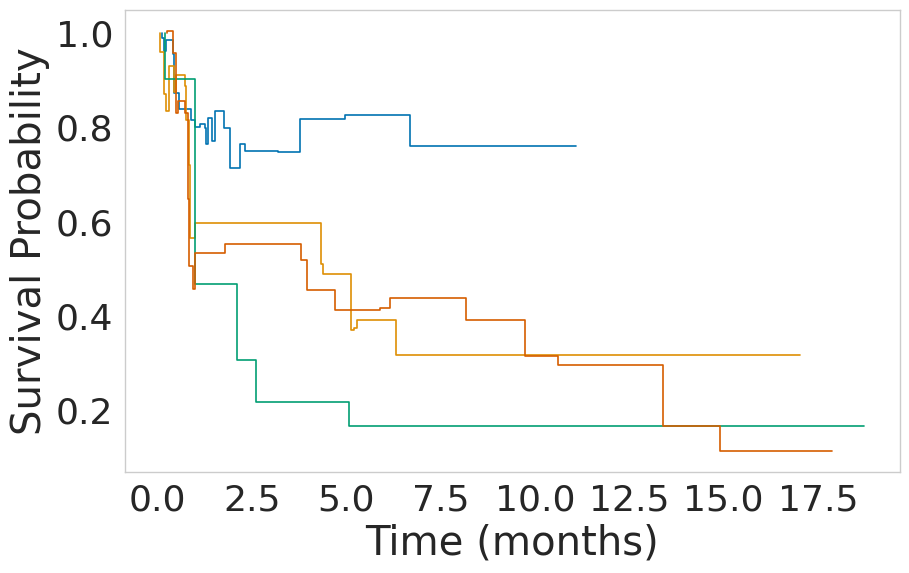

In [28]:
plt.figure(figsize=(10,6))
risk_groups = df_lnto['Disease'].unique()
for group in ['AN', 'GN', 'PKD', 'Other']:
    # Filter the data for the current group
    group_data = df_lnto[df_lnto['Disease'] == group]
    times = np.array(group_data['Time'])
    S = np.array(group_data['S'])
    #sort by time and respective survival probability
    times, S = zip(*sorted(zip(times, S)))
    plt.step(times, S, label=group)
    
plt.xlabel('Time (months)', size=29)
plt.xticks(size=26)
plt.ylabel('Survival Probability', size=29)
plt.yticks(size=26)
plt.set_ylim = (0,1)
#plt.title('Survival Probability for IPSS-R Risk Groups')
plt.legend(title='Risk Group')
plt.legend().remove()
plt.grid(False)
plt.show()


In [29]:
df_lnto, median_lnto = lnto_grouped(df, 2, 'Disease')
median_lnto

,Disease,Median_Time,CI_lower_time,CI_upper_time
0,AN,1.93,1.13,NaN
1,GN,0.87,0.30,NaN
2,Other,9.73,3.80,NaN
3,PKD,5.07,1.00,NaN


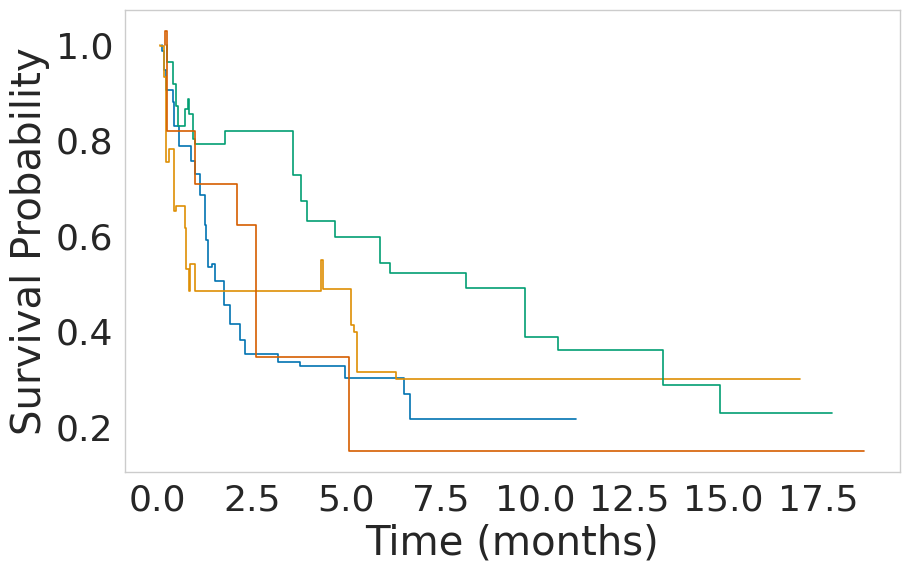

In [30]:
plt.figure(figsize=(10,6))
risk_groups = df_lnto['Disease'].unique()
for group in ['AN', 'GN', 'Other', 'PKD']:
    # Filter the data for the current group
    group_data = df_lnto[df_lnto['Disease'] == group]
    times = np.array(group_data['Time'])
    S = np.array(group_data['S'])
    #sort by time and respective survival probability
    times, S = zip(*sorted(zip(times, S)))
    plt.step(times, S, label=group)
    
plt.xlabel('Time (months)', size=29)
plt.xticks(size=26)
plt.ylabel('Survival Probability', size=29)
plt.yticks(size=26)
plt.set_ylim = (0,1)
#plt.title('Survival Probability for IPSS-R Risk Groups')
plt.legend(title='Risk Group')
plt.legend().remove()
plt.grid(False)
plt.show()


In [31]:
df_lnto, median_lnto = lnto_grouped(df, 3, 'Disease')
median_lnto

,Disease,Median_Time,CI_lower_time,CI_upper_time
0,AN,1.43,1.00,NaN
1,GN,4.33,0.30,NaN
2,Other,8.17,1.00,NaN
3,PKD,18.73,5.07,NaN


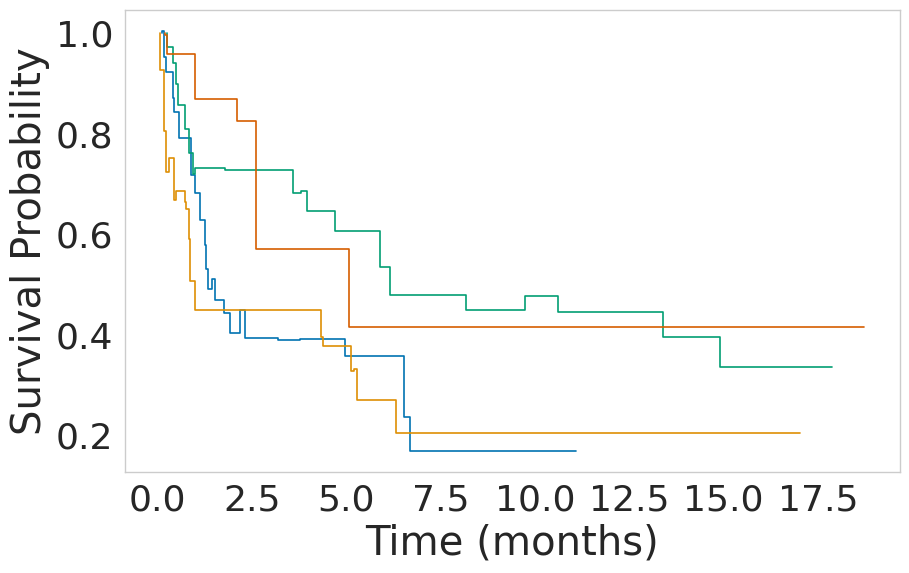

In [32]:
plt.figure(figsize=(10,6))
risk_groups = df_lnto['Disease'].unique()
for group in ['AN', 'GN', 'Other', 'PKD']:
    # Filter the data for the current group
    group_data = df_lnto[df_lnto['Disease'] == group]
    times = np.array(group_data['Time'])
    S = np.array(group_data['S'])
    #sort by time and respective survival probability
    times, S = zip(*sorted(zip(times, S)))
    plt.step(times, S, label=group)
    
plt.xlabel('Time (months)', size=29)
plt.xticks(size=26)
plt.ylabel('Survival Probability', size=29)
plt.yticks(size=26)
plt.set_ylim = (0,1)
#plt.title('Survival Probability for IPSS-R Risk Groups')
plt.legend(title='Risk Group')
plt.legend().remove()
plt.grid(False)
plt.show()


### RRR Simulation

In [33]:
#get unique risks groups
risk_groups = df['Disease'].unique()
risk_groups

array(['Other', 'GN', 'AN', 'PKD'], dtype=object)

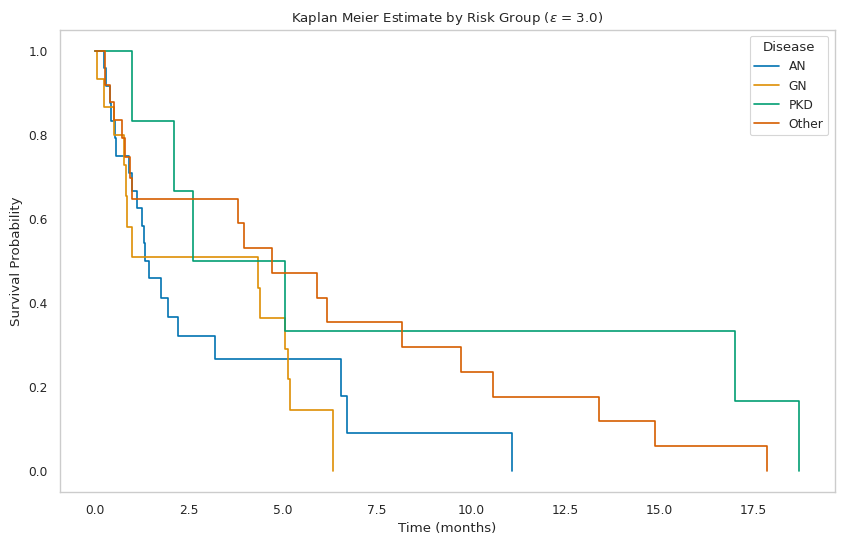

In [34]:
# set the coin bias
#e1 = 1 -> p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#e1 = 2 -> p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
#e1 = 3 -> p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
n = len(risk_groups)

#p = (np.exp(1)*(n-1)-1)/((1+np.exp(1))*(n-1))
#p = (math.pow(np.exp(1),2)*(n-1)-1)/((1+math.pow(np.exp(1),2))*(n-1))
p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
e1 = verify_epsilon(p, n)
# privatize the IPSS-R category
df['Privatized Disease'] = df['Disease'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p))

groups = df['Privatized Disease']
ix_an = (groups == 'AN')
ix_gn = (groups == 'GN')
ix_pkd = (groups == 'PKD')
ix_o = (groups == 'Other')

km = KaplanMeierFitter()

plt.figure(figsize=(10, 6))  # Setting the figure size

# Fitting and plotting for each risk group
medians = []
medians_ci = []
for ix, label in zip([ix_an, ix_gn, ix_pkd, ix_o], ['AN', 'GN', 'PKD', 'Other']):
    km.fit(df['Time'][ix], df['Status'][ix], label=label)
    medians.append(km.median_survival_time_)
    medians_ci.append(median_survival_times(km.confidence_interval_))
    km.plot(ax=plt.gca(), ci_show=False)  # Use the current axes, overlaying the plots

plt.title(r'Kaplan Meier Estimate by Risk Group ($\epsilon$ = {})'.format(round(e1, 2)))
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend(title='Disease', loc = 'best')
plt.grid(False)
plt.show()

In [35]:
for median, ci in zip(medians, medians_ci):
    print('Median survival time:', "{:.2f}".format(median))
    print(ci)

Median survival time: 1.43
     AN_lower_0.95  AN_upper_0.95
0.5            0.9            3.2
Median survival time: 4.33
     GN_lower_0.95  GN_upper_0.95
0.5            0.5       5.133333
Median survival time: 2.60
     PKD_lower_0.95  PKD_upper_0.95
0.5             1.0       18.733333
Median survival time: 4.70
     Other_lower_0.95  Other_upper_0.95
0.5          0.933333          9.733333


In [36]:
p = (math.pow(np.exp(1),3)*(n-1)-1)/((1+math.pow(np.exp(1),3))*(n-1))
e = verify_epsilon(p, n)
times = 100

# Fitting and plotting for each risk group
medians = []
medians_ci = []
dfs = []
for i in range(1, times+1):
    df['Privatized Disease'] = df['Disease'].apply(lambda x: revised_coin_toss(x, risk_groups, n, p))
    groups = df['Privatized Disease']
    ix_an = (groups == 'AN')
    ix_gn = (groups == 'GN')
    ix_pkd = (groups == 'PKD')
    ix_o = (groups == 'Other')
    
    km = KaplanMeierFitter()
    for ix, label in zip([ix_an, ix_gn, ix_pkd, ix_o], ['AN', 'GN', 'PKD', 'Other']):
        km.fit(df['Time'][ix], df['Status'][ix], label=label)
        medians.append(km.median_survival_time_)
        medians_ci.append(median_survival_times(km.confidence_interval_))
    results_dp = lifelines.statistics.pairwise_logrank_test(df['Time'], df['Privatized Disease'], df['Status'])
    temp = pd.DataFrame(results_dp.summary)
    temp['iteration'] = i
    dfs.append(temp)

In [37]:
results = lifelines.statistics.pairwise_logrank_test(df['Time'], df['Disease'], df['Status'])

In [38]:
results_dp = lifelines.statistics.pairwise_logrank_test(df['Time'], df['Privatized Disease'], df['Status'])

In [39]:
#concatenate all df in dfs, summing the values of the test statistic and counting the proportion of p-values < 0.05 for each index
df_results = pd.concat(dfs)
df_results = df_results.reset_index()
#group by level_0 and level_1 and sum the values of the test statistic and count the proportion of p-values < 0.05
df_results = df_results.groupby(['level_0', 'level_1']).agg({'test_statistic': 'sum', 'p': lambda x: (x < 0.05).sum()/len(x)}).reset_index()

#pivot the table
df_results = df_results.pivot(index='level_0', columns='level_1', values='p')

df_results


level_1,GN,Other,PKD
level_0,,,
AN,0.0,0.00,0.03
GN,NaN,0.02,0.00
Other,NaN,NaN,0.00


In [40]:
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
             test_statistic    p  -log2(p)
AN    GN               0.01 0.93      0.11
      Other            1.69 0.19      2.37
      PKD              1.09 0.30      1.75
GN    Other            0.99 0.32      1.64
      PKD              0.60 0.44      1.19
Other PKD              0.26 0.61      0.71

In [41]:
results_dp.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
             test_statistic    p  -log2(p)
AN    GN               0.11 0.75      0.42
      Other            0.85 0.36      1.48
      PKD              0.79 0.37      1.42
GN    Other            0.63 0.43      1.23
      PKD              0.60 0.44      1.19
Other PKD              0.39 0.53      0.91